In [1]:
import sys
sys.path.append('/Users/ianleefmans/Desktop/stock-sentiment/utils')
from data import Database, ScrapeWSB, Stock
from datahelper import PostDataset, CommentDataset, get_indices
from torch.utils.data import DataLoader
from inference import RunInference
from models import FineTuneBaseModel, FineTuneClassifier
%cd /Users/ianleefmans/Desktop/stock-sentiment

/Users/ianleefmans/Desktop/stock-sentiment


In [2]:
import transformers
import torch
from transformers import BertTokenizer, BertForSequenceClassification

### DB Queries

In [4]:

db = Database()
db.use_database('DB1')

print(db.query('show tables;'))

connection established
[(datetime.datetime(2021, 10, 6, 18, 26, 27),)]
[('COMMENTS',), ('POSTS',), ('STOCKS',)]


In [7]:
db.query("SELECT * FROM STOCKS WHERE STOCK_ID='AMC' AND LAST_SCRAPED >= DATE_SUB(NOW(),INTERVAL 55 MINUTE)")

[('AMC', datetime.datetime(2021, 6, 6, 22, 15, 44))]

In [16]:
db.query("SELECT POST_ID FROM POSTS WHERE STOCK_ID='{}' AND LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = '{}'), INTERVAL {} HOUR);".format('BB', 'BB', 6))



[('nx2ihx',),
 ('nxcb5h',),
 ('nxp5r6',),
 ('nxtjj4',),
 ('nxv9jr',),
 ('nxx9sz',),
 ('ny01wx',),
 ('nz6tgd',),
 ('nzf0mj',),
 ('nzjcfg',)]

In [86]:
db.query("SELECT POST_ID FROM POSTS WHERE STOCK_ID='{}' AND LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = '{}'),INTERVAL {} HOUR);".format('AAPL','AAPL',6))



[('nv0h06',)]

In [85]:
db.query("SELECT LAST_SCRAPED FROM POSTS WHERE LAST_SCRAPED >= DATE_SUB((SELECT LAST_SCRAPED FROM STOCKS WHERE STOCK_ID = 'AAPL'),INTERVAL 6 HOUR);")
         
         
         


[(datetime.datetime(2021, 6, 14, 18, 21, 27),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),),
 (datetime.datetime(2021, 6, 14, 14, 27, 44),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),),
 (datetime.datetime(2021, 6, 14, 14, 27, 43),)]

### Running Inference

In [2]:
indices = get_indices("GME", inference=True, scrape_time=6)

connection established
[(datetime.datetime(2021, 10, 6, 19, 48, 59),)]


In [3]:
post_train = PostDataset(512, indices['post_ids'])



connection established
[(datetime.datetime(2021, 10, 6, 19, 49, 1),)]


In [4]:
post_trainloader = DataLoader(
    dataset=post_train, 
    batch_size=3, 
    num_workers=0,
    shuffle=True
    )

In [5]:
sample = iter(post_trainloader).next()

In [6]:
sample


{'post': ['GIANT $RUN LOVING APE BALLS OUT.....$BB $AMC $GME',
  'Jim Cramer WSB FOMO- GME and AMC bull!',
  'Daily option statistics for AMC, CLNE, BB, WISH, GME, WKHS, CLOV, PLTR, CLF, and others.'],
 'post_input_ids': tensor([[ 101,  144, 9984,  ...,    0,    0,    0],
         [ 101, 3104,  140,  ...,    0,    0,    0],
         [ 101, 5732, 5146,  ...,    0,    0,    0]]),
 'post_attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 'target': tensor([-1, -1, -1]),
 'date': tensor([1.6240e+09, 1.6240e+09, 1.6240e+09], dtype=torch.float64)}

In [7]:
model = FineTuneClassifier()

out = model(input_ids=sample['post_input_ids'], attention_masks=sample['post_attention_mask'])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [8]:
out

tensor([[0.5016, 0.4984],
        [0.5107, 0.4893],
        [0.4868, 0.5132]], grad_fn=<SoftmaxBackward>)

### Stock Predictions

In [2]:
from inference import RunInference

run =RunInference('GME')
output = run.evaluate()

connection established
[(datetime.datetime(2021, 10, 16, 20, 2, 31),)]
connection established
[(datetime.datetime(2021, 10, 16, 20, 2, 33),)]


Determining Sentiment From Posts:   0%|          | 0/1 [00:00<?, ?it/s]

connection established
[(datetime.datetime(2021, 10, 16, 20, 2, 35),)]


Determining Sentiment From Comments: 100%|██████████| 1/1 [00:10<00:00, 10.34s/it]


In [3]:
output

{'avg_post_probs': tensor([0.3999, 0.6001]),
 'avg_comment_probs': tensor([0.7995, 0.2005]),
 'all_post_probs': tensor([[9.9936e-01, 6.3518e-04],
         [2.2896e-04, 9.9977e-01],
         [2.2188e-04, 9.9978e-01],
         [9.9945e-01, 5.4841e-04],
         [1.7562e-04, 9.9982e-01]]),
 'all_comment_probs': tensor([[9.9924e-01, 7.5561e-04],
         [3.0345e-04, 9.9970e-01],
         [9.9924e-01, 7.5804e-04],
         [9.9927e-01, 7.3070e-04],
         [9.9933e-01, 6.6655e-04]]),
 'all_post_dates': tensor([1.6336e+09, 1.6335e+09, 1.6336e+09, 1.6335e+09, 1.6336e+09],
        dtype=torch.float64),
 'all_comment_dates': tensor([1.6336e+09, 1.6335e+09, 1.6336e+09, 1.6335e+09, 1.6336e+09],
        dtype=torch.float64),
 'max_post_prob': 0.9998244643211365,
 'max_comment_prob': 0.9996966123580933,
 'max_post': '$77K to $233K, Roller coaster journey. Top Gainers: GME, SPCE, DOCN, ASAN, WORK, SPOT',
 'max_comment': "Alright SDC, if you can multiply your stock price by 100 right now, I will be

In [4]:
from forecast import Forecast

get_stock = Forecast("GME", output)

100%|██████████| 722/722 [00:01<00:00, 425.69it/s]


In [38]:
preds = get_stock.arima(periods=200)


/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [39]:
preds

/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,timestamp,sentiment,close_price,is_pred
0,2021-10-13 16:07:00,0.500291,184.800000,0
1,2021-10-13 16:23:00,0.500291,184.750000,0
2,2021-10-13 16:29:00,0.500291,184.900000,0
3,2021-10-13 17:10:00,0.500291,184.250000,0
4,2021-10-13 17:30:00,0.500291,184.500000,0
...,...,...,...,...
917,2021-10-15 23:15:00,0.500289,184.114044,1
918,2021-10-15 23:16:00,0.500289,184.114307,1
919,2021-10-15 23:17:00,0.500289,184.114574,1
920,2021-10-15 23:18:00,0.500289,184.114747,1


/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


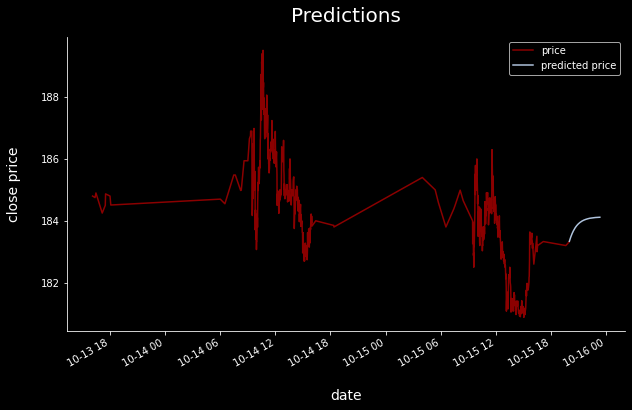

In [40]:
from matplotlib import pyplot as plt
plt.style.use('dark_background')

fig, ax = plt.subplots(figsize=(10,6))



preds.loc[preds.is_pred==0,:].plot.line(ax=ax, x="timestamp", y="close_price", color='darkred')
preds.loc[preds.is_pred==1,:].plot.line(ax=ax, x="timestamp", y="close_price", color='lightsteelblue')

ax.set_title("Predictions", fontdict = {'fontsize': 20}, pad = 15)
ax.set_xlabel('date', fontsize=14, labelpad = 20)
ax.set_ylabel('close price', fontsize=14, labelpad=20)

ax.legend(['price', 'predicted price'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);

In [9]:
get_stock.stock_data

,close,high,low,open,status,timestamp,volume,highlow_percent,highlow_percent_t1,sentiment
0,183.28,183.78,182.90,183.78,ok,2021-10-13 15:43:00,16293,0.995212,NaN,0.500291
1,183.09,183.25,182.93,183.23,ok,2021-10-13 15:44:00,6541,0.998254,NaN,0.500291
2,183.07,183.08,183.00,183.00,ok,2021-10-13 15:45:00,1472,0.999563,NaN,0.500291
3,182.93,183.05,182.88,183.05,ok,2021-10-13 15:46:00,2546,0.999071,NaN,0.500291
4,183.09,183.09,182.87,183.00,ok,2021-10-13 15:47:00,5402,0.998798,NaN,0.500291
...,...,...,...,...,...,...,...,...,...,...
736,183.00,183.00,183.00,183.00,ok,2021-10-15 16:29:00,185,1.000000,0.998541,0.500291
737,183.20,183.20,183.20,183.20,ok,2021-10-15 16:33:00,114,1.000000,0.998541,0.500291
738,183.33,183.33,183.33,183.33,ok,2021-10-15 17:10:00,371,1.000000,0.998541,0.500291
739,183.20,183.20,183.20,183.20,ok,2021-10-15 19:37:00,249,1.000000,0.998541,0.500291


In [4]:
get_stock.assign_sentiment()
get_stock.stock_data

,close,high,low,open,status,timestamp,volume,highlow_percent,highlow_percent_t1,sentiment
0,168.78,169.130,168.78,169.000,ok,2021-10-06 13:06:00,1973,0.997931,NaN,0.799546
1,168.60,168.775,168.60,168.775,ok,2021-10-06 13:07:00,1470,0.998963,NaN,0.799546
2,168.80,168.800,168.50,168.640,ok,2021-10-06 13:09:00,4365,0.998223,NaN,0.799546
3,168.55,168.550,168.55,168.550,ok,2021-10-06 13:11:00,1236,1.000000,NaN,0.799546
4,168.81,168.810,168.81,168.810,ok,2021-10-06 13:12:00,248,1.000000,NaN,0.799546
...,...,...,...,...,...,...,...,...,...,...
781,172.45,172.690,172.45,172.690,ok,2021-10-08 16:16:00,375,0.998610,0.999004,0.799546
782,172.45,172.450,172.45,172.450,ok,2021-10-08 16:17:00,198,1.000000,0.999004,0.799546
783,172.95,172.950,172.95,172.950,ok,2021-10-08 17:11:00,179,1.000000,0.999004,0.799546
784,172.72,172.720,172.72,172.720,ok,2021-10-08 17:34:00,148,1.000000,0.999004,0.799546


In [5]:

table = get_stock.sentiment
table

,date,sentiment
0,2021-06-17 03:20:00,0.999614
1,2021-06-17 06:06:40,0.999814
2,2021-06-17 22:46:40,0.999831
3,2021-06-18 04:20:00,0.999502
4,2021-06-18 07:06:40,0.799546


In [6]:
data = get_stock.stock_data

In [123]:
data.head()

,close,high,low,open,status,timestamp,volume,highlow_percent,highlow_percent_t1,sentiment
0,168.78,169.130,168.78,169.000,ok,2021-10-06 13:06:00,1973,0.997931,NaN,0.799546
1,168.60,168.775,168.60,168.775,ok,2021-10-06 13:07:00,1470,0.998963,NaN,0.799546
2,168.80,168.800,168.50,168.640,ok,2021-10-06 13:09:00,4365,0.998223,NaN,0.799546
3,168.55,168.550,168.55,168.550,ok,2021-10-06 13:11:00,1236,1.000000,NaN,0.799546
4,168.81,168.810,168.81,168.810,ok,2021-10-06 13:12:00,248,1.000000,NaN,0.799546


In [125]:
data.timestamp.diff().mean()

Timedelta('0 days 00:04:11.464968152')

In [134]:
data.timestamp.diff().median()*3

Timedelta('0 days 00:03:00')

In [129]:
data.timestamp.max()

Timestamp('2021-10-08 19:56:00')

In [128]:
data.timestamp.max() + data.timestamp.diff().median()

Timestamp('2021-10-08 19:57:00')

In [ ]:
mod = ARIMA(endog=data.close, exog = self.stock_data.highlow_percent, order=(1, 0, 0))

In [12]:
from statsmodels.tsa.arima.model import ARIMA

mod = ARIMA(endog=data.sentiment, order=(1, 0, 0))

In [13]:
res = mod.fit()

/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


In [56]:
predictions = []
def pred(df, count):
    if count == 0:
        return
    
    mod = ARIMA(endog=df, order=(1, 0, 0))
    res = mod.fit()
    
    predictions.append(float(res.forecast()))
    
    
    pred(df+[float(res.forecast())], count-1)



In [57]:
pred(list(data.sentiment), 10)

/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/Users/ianleefmans/opt/anaconda3/envs/StockSentiment/lib/python3.7/site-packages/statsmodels/base/model.

In [130]:
len(predictions)

10

In [58]:
predictions

[0.7995407913533179,
 0.7995407770139782,
 0.7995407793797036,
 0.7995407826003444,
 0.7995407878415857,
 0.7995407945813624,
 0.7995408025039776,
 0.7995408113972577,
 0.7995408211084032,
 0.7995408315218733]

In [116]:
predictions2 = []
def pred2(df1, df2):
    if len(df1)==len(df2):
        return
    
    mod = ARIMA(endog=df1, exog = df2[0:len(df1), 0], order=(1, 0, 0))
    res = mod.fit()
    
    predictions2.append(res.forecast(exog=[df2[len(df1)-1, 0]]))
    
    
    pred2(df1+[float(res.forecast(exog=[df2[len(df1)-1, 0]]))], df2)

In [120]:
pred2(list(data.close), np.add(np.array(list(data.sentiment)+predictions).reshape(-1, 1), np.random.randn(len(list(data.sentiment)+predictions), 1).reshape(-1, 1)))




In [131]:
len(predictions2)

20

In [121]:
predictions2


[array([172.79432499]),
 array([172.78882544]),
 array([172.78329517]),
 array([172.7780081]),
 array([172.7725928]),
 array([172.76761834]),
 array([172.76248924]),
 array([172.75788214]),
 array([172.75310902]),
 array([172.74836839]),
 array([172.79441661]),
 array([172.78896918]),
 array([172.78349531]),
 array([172.77819952]),
 array([172.77289296]),
 array([172.76771112]),
 array([172.7626385]),
 array([172.75762023]),
 array([172.75270978]),
 array([172.74784666])]